In [1]:
import os
import random
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import kagglehub
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.nn.functional as F

In [2]:
# 1. Original IPN Hand dataset (videos)
ipn_path = kagglehub.dataset_download("soumicksarker/ipn-hand-dataset")
print("IPN dataset:", ipn_path)

# 2. Your segmentation masks dataset
seg_path = kagglehub.dataset_download("johnsonyang123321/ipn-hand-data-segmented")
seg_dir = os.path.join(seg_path, "segment")  # should now exist properly
print("Segmentation masks dir:", seg_dir)
print("Sample sequences:", os.listdir(seg_dir)[:5])

IPN dataset: C:\Users\zxjia\.cache\kagglehub\datasets\soumicksarker\ipn-hand-dataset\versions\7
Segmentation masks dir: C:\Users\zxjia\.cache\kagglehub\datasets\johnsonyang123321\ipn-hand-data-segmented\versions\1\segment
Sample sequences: ['segment']


Segmentation sequences available: ['1CM1_1_R__217', '1CM1_1_R__218', '1CM1_1_R__219', '1CM1_1_R__220', '1CM1_2_R__221', '1CM1_2_R__222', '1CM1_2_R__223', '1CM1_2_R__224', '1CM1_3_R__225', '1CM1_3_R__226']
Selected sequence: 1CV12_12_R__90
Extracted 5 frames from 1CV12_12_R__90.avi
Frame 0 shape: (256, 256, 3), Mask 0 shape: (256, 256)
Frame 1 shape: (256, 256, 3), Mask 1 shape: (256, 256)
Frame 2 shape: (256, 256, 3), Mask 2 shape: (256, 256)
Frame 3 shape: (256, 256, 3), Mask 3 shape: (256, 256)
Frame 4 shape: (256, 256, 3), Mask 4 shape: (256, 256)


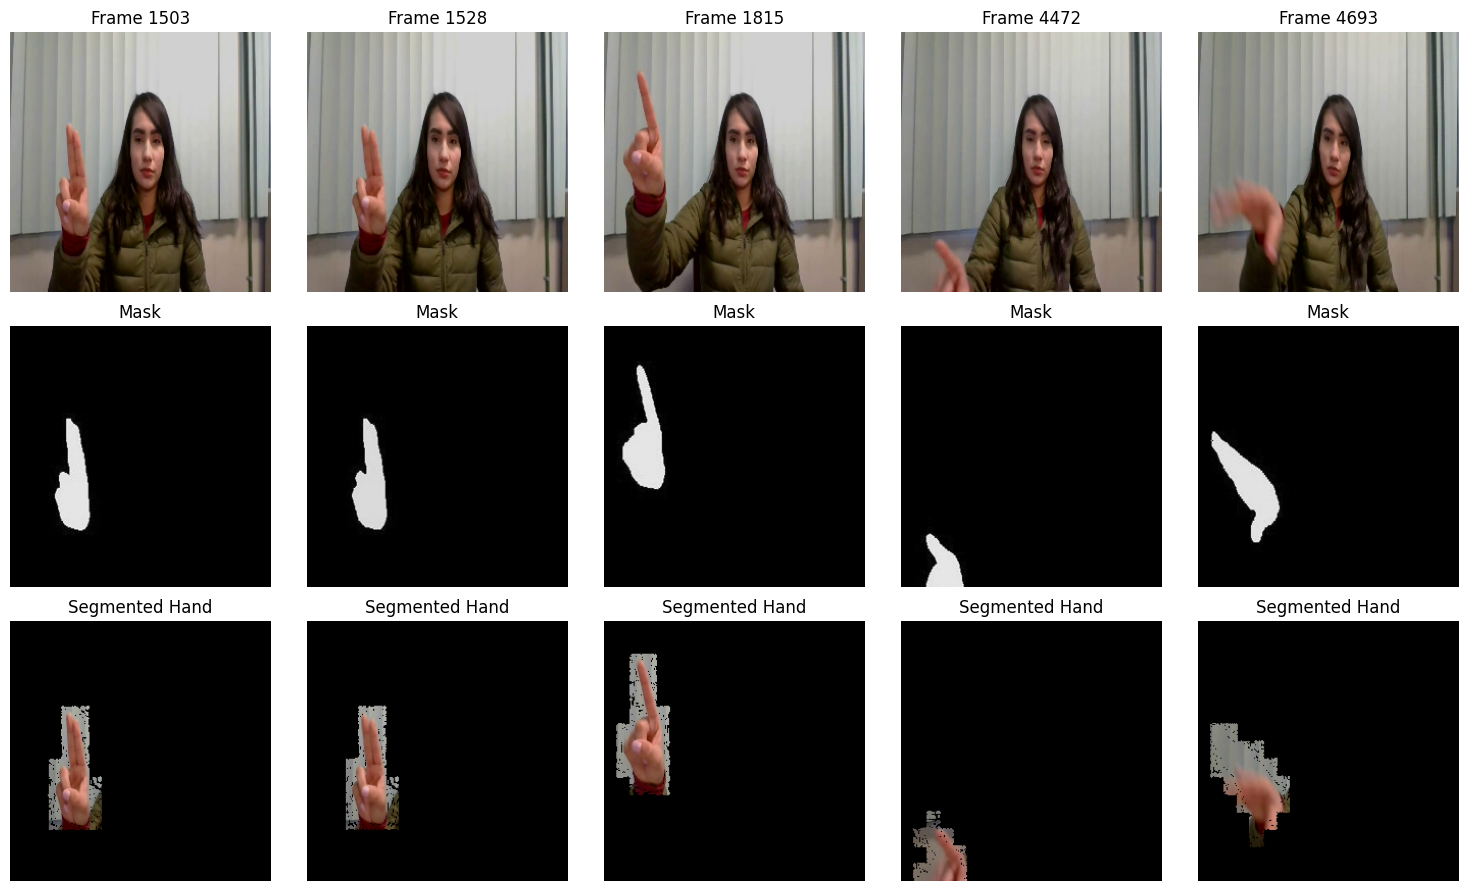

In [4]:
# --- Paths ---
videos_dir = os.path.join(ipn_path, "videos/videos")  # raw video files
seg_dir = os.path.join(seg_path, "segment/segment")   # segmentation sequences

# --- 1. List actual segmentation sequence folders ---
seg_sequences = [d for d in os.listdir(seg_dir) if os.path.isdir(os.path.join(seg_dir, d))]
print("Segmentation sequences available:", seg_sequences[:10])

if not seg_sequences:
    raise ValueError("No segmentation sequences found!")

# --- 2. Pick a random segmentation sequence ---
seq_name = random.choice(seg_sequences)
print("Selected sequence:", seq_name)

# --- 3. Find the corresponding video ---
video_file = seq_name + ".avi"
video_path = os.path.join(videos_dir, video_file)
if not os.path.exists(video_path):
    raise ValueError(f"Video {video_file} not found in videos folder!")

# --- 4. Extract a few frames from the video ---
cap = cv2.VideoCapture(video_path)
frames = []
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Pick 5 random frames
sample_indices = sorted(random.sample(range(frame_count), min(5, frame_count)))

idx = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
    if idx in sample_indices:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # Resize frame to 256x256
        frame_rgb = cv2.resize(frame_rgb, (256, 256))
        frames.append(frame_rgb)
    idx += 1
cap.release()
print(f"Extracted {len(frames)} frames from {video_file}")

# --- 5. Load corresponding segmentation masks ---
mask_seq_path = os.path.join(seg_dir, seq_name)
mask_files = sorted(os.listdir(mask_seq_path))
masks = []
for i in sample_indices:
    m = Image.open(os.path.join(mask_seq_path, mask_files[i])).convert("L")
    # Resize mask to 256x256
    m = m.resize((256, 256))
    mask_array = np.array(m)
    masks.append(mask_array)

# --- 5b. Print shapes for verification ---
for i, (f, m) in enumerate(zip(frames, masks)):
    print(f"Frame {i} shape: {f.shape}, Mask {i} shape: {m.shape}")

# --- 6. Display frames, masks, and segmented hands ---
plt.figure(figsize=(15, 9))
for i, (f, m) in enumerate(zip(frames, masks)):
    # Original frame
    plt.subplot(3, len(frames), i + 1)
    plt.imshow(f)
    plt.title(f"Frame {sample_indices[i]}")
    plt.axis("off")

    # Mask
    plt.subplot(3, len(frames), len(frames) + i + 1)
    plt.imshow(m, cmap='gray')
    plt.title("Mask")
    plt.axis("off")

    # Segmented hand
    segmented = f.copy()
    segmented[m == 0] = 0  # zero out background
    plt.subplot(3, len(frames), 2*len(frames) + i + 1)
    plt.imshow(segmented)
    plt.title("Segmented Hand")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [5]:
class HandSegDataset(Dataset):
    def __init__(self, videos_dir, seg_dir, transform=None, frames_per_seq=10, max_sequences=None):
        self.videos_dir = videos_dir
        self.seg_dir = seg_dir
        self.seq_names = sorted(os.listdir(seg_dir))

        # Limit to a subset of sequences
        if max_sequences is not None:
            self.seq_names = self.seq_names[:max_sequences]

        self.samples = []
        self.frames_per_seq = frames_per_seq

        for seq in self.seq_names:
            mask_seq_path = os.path.join(seg_dir, seq)
            mask_files = sorted(os.listdir(mask_seq_path))
            video_file = os.path.join(videos_dir, seq + ".avi")

            cap = cv2.VideoCapture(video_file)
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            cap.release()

            n = min(frame_count, len(mask_files))
            sampled_indices = sorted(random.sample(range(n), min(n, frames_per_seq)))

            for i in sampled_indices:
                self.samples.append((video_file, i, os.path.join(mask_seq_path, mask_files[i])))

        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_file, frame_idx, mask_file = self.samples[idx]

        # Load frame
        cap = cv2.VideoCapture(video_file)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        cap.release()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = Image.fromarray(frame)

        # Load mask
        mask = Image.open(mask_file).convert("L")

        if self.transform:
            frame = self.transform(frame)
            mask = mask.resize(frame.shape[1:], resample=Image.NEAREST)
            mask = np.array(mask)
            mask = (mask > 127).astype(np.float32)
        else:
            frame = T.ToTensor()(frame)
            mask = np.array(mask)
            mask = (mask > 127).astype(np.float32)

        mask = torch.tensor(mask).unsqueeze(0)
        return frame, mask


In [6]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64,128,256,512]):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        # Encoder
        for f in features:
            self.downs.append(self.conv_block(in_channels, f))
            in_channels = f

        # Bottleneck
        self.bottleneck = self.conv_block(features[-1], features[-1]*2)

        # Decoder
        for f in reversed(features):
            self.ups.append(nn.ConvTranspose2d(f*2, f, kernel_size=2, stride=2))
            self.ups.append(self.conv_block(f*2, f))

        # Final output
        self.final = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = F.max_pool2d(x, 2)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skip_connections[idx//2]
            if x.shape != skip.shape:
                x = F.interpolate(x, size=skip.shape[2:])
            x = torch.cat([skip, x], dim=1)
            x = self.ups[idx+1](x)

        return torch.sigmoid(self.final(x))

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Dataset and DataLoader
transform = T.Compose([
    T.ToTensor(),
    T.Resize((256,256))
])

dataset = HandSegDataset(videos_dir, seg_dir, transform=transform, frames_per_seq=20, max_sequences=100)
loader = DataLoader(dataset, batch_size=4, shuffle=True)
model = UNet().to(device)



In [ ]:
raise Exception("Stop here")

In [ ]:
# Training
# Hyperparameters
batch_size = 4
lr = 1e-3
epochs = 15

# Model, loss, optimizer
model = UNet().to(device)
criterion = nn.BCELoss()  # Binary segmentation
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_history = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for imgs, masks in loader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(loader):.4f}")


In [ ]:
plt.figure(figsize=(6,4))
plt.plot(range(1, epochs+1), loss_history, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [10]:
save_path = os.path.join("models", "hand_seg_model.pth")
torch.save(model.state_dict(), save_path)


In [11]:
# Pull Saved model
model = UNet().to(device)
model.load_state_dict(torch.load(save_path, map_location=device))

<All keys matched successfully>

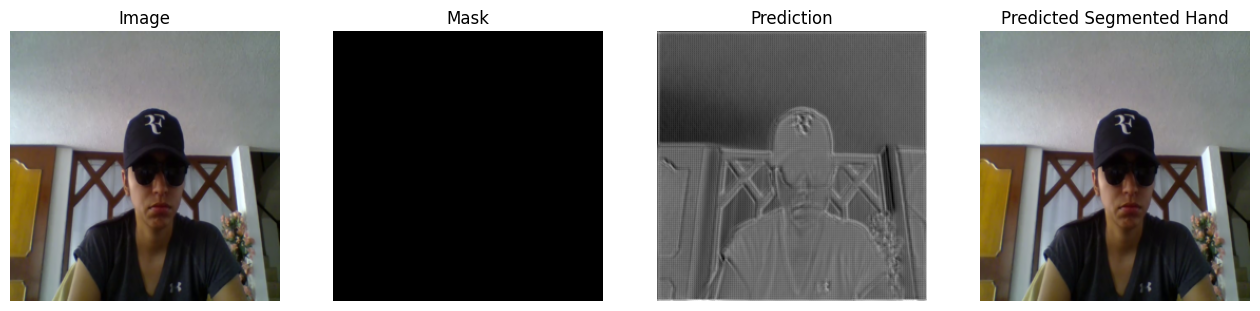

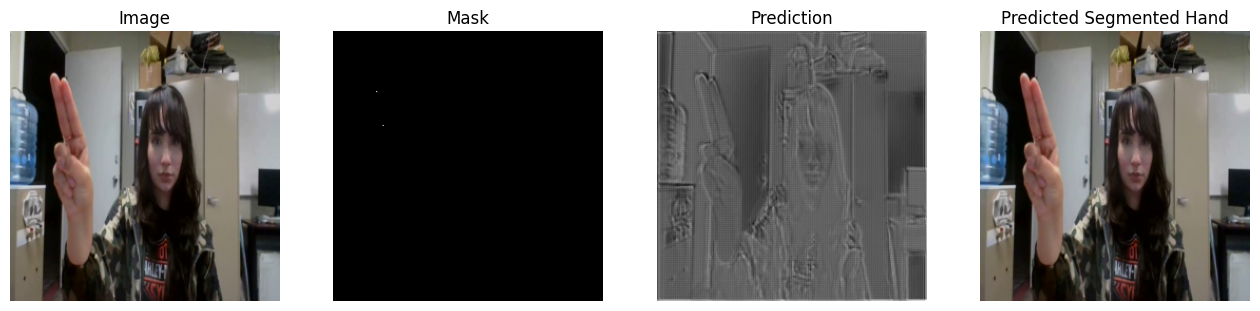

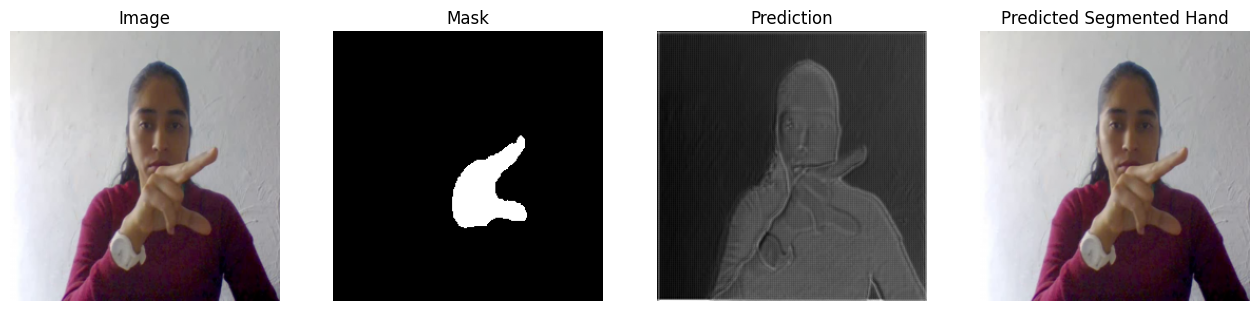

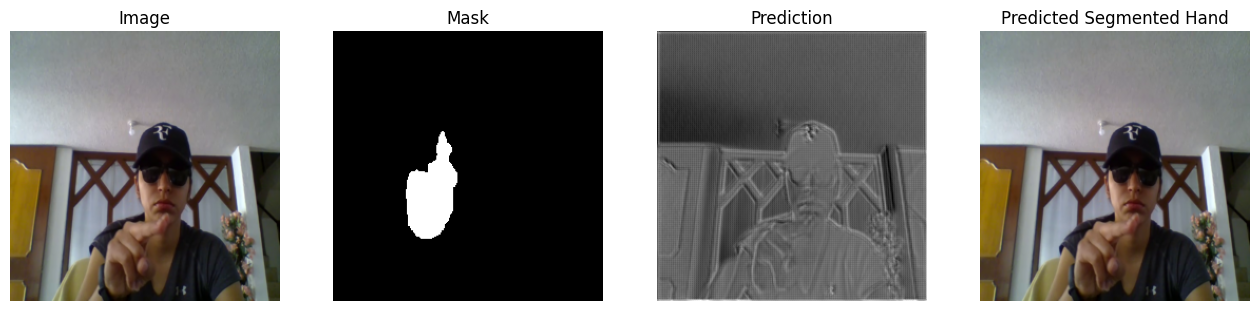

In [12]:
model.eval()
with torch.no_grad():
    imgs, masks = next(iter(loader))
    imgs, masks = imgs.to(device), masks.to(device)
    preds = model(imgs)

for i in range(min(4, imgs.size(0))):
    plt.figure(figsize=(16,4))

    # Original image
    plt.subplot(1,4,1)
    plt.imshow(imgs[i].cpu().permute(1,2,0))
    plt.title("Image")
    plt.axis("off")

    # Ground truth mask
    plt.subplot(1,4,2)
    plt.imshow(masks[i,0].cpu(), cmap='gray')
    plt.title("Mask")
    plt.axis("off")

    # Predicted mask
    pred_mask = preds[i,0].cpu()
    plt.subplot(1,4,3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Prediction")
    plt.axis("off")

    # Segmented predicted hand
    pred_mask_bin = (pred_mask > 0.2).float()   # threshold mask
    segmented = imgs[i].cpu() * pred_mask_bin   # apply mask
    segmented = segmented.permute(1,2,0)         # CHW → HWC

    plt.subplot(1,4,4)
    plt.imshow(segmented)
    plt.title("Predicted Segmented Hand")
    plt.axis("off")

    plt.show()
